# ぬ

1
Optimal
Class: A
人数: 40
学生: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class: B
人数: 39
学生: [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317]

Class: C
人数: 40
学生: [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318]

Class: D
人数: 40
学生: [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316]

Class: E
人数: 40
学生: [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197, 243, 244, 247, 249, 25

c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  fig.canvas.print_figure(bytes

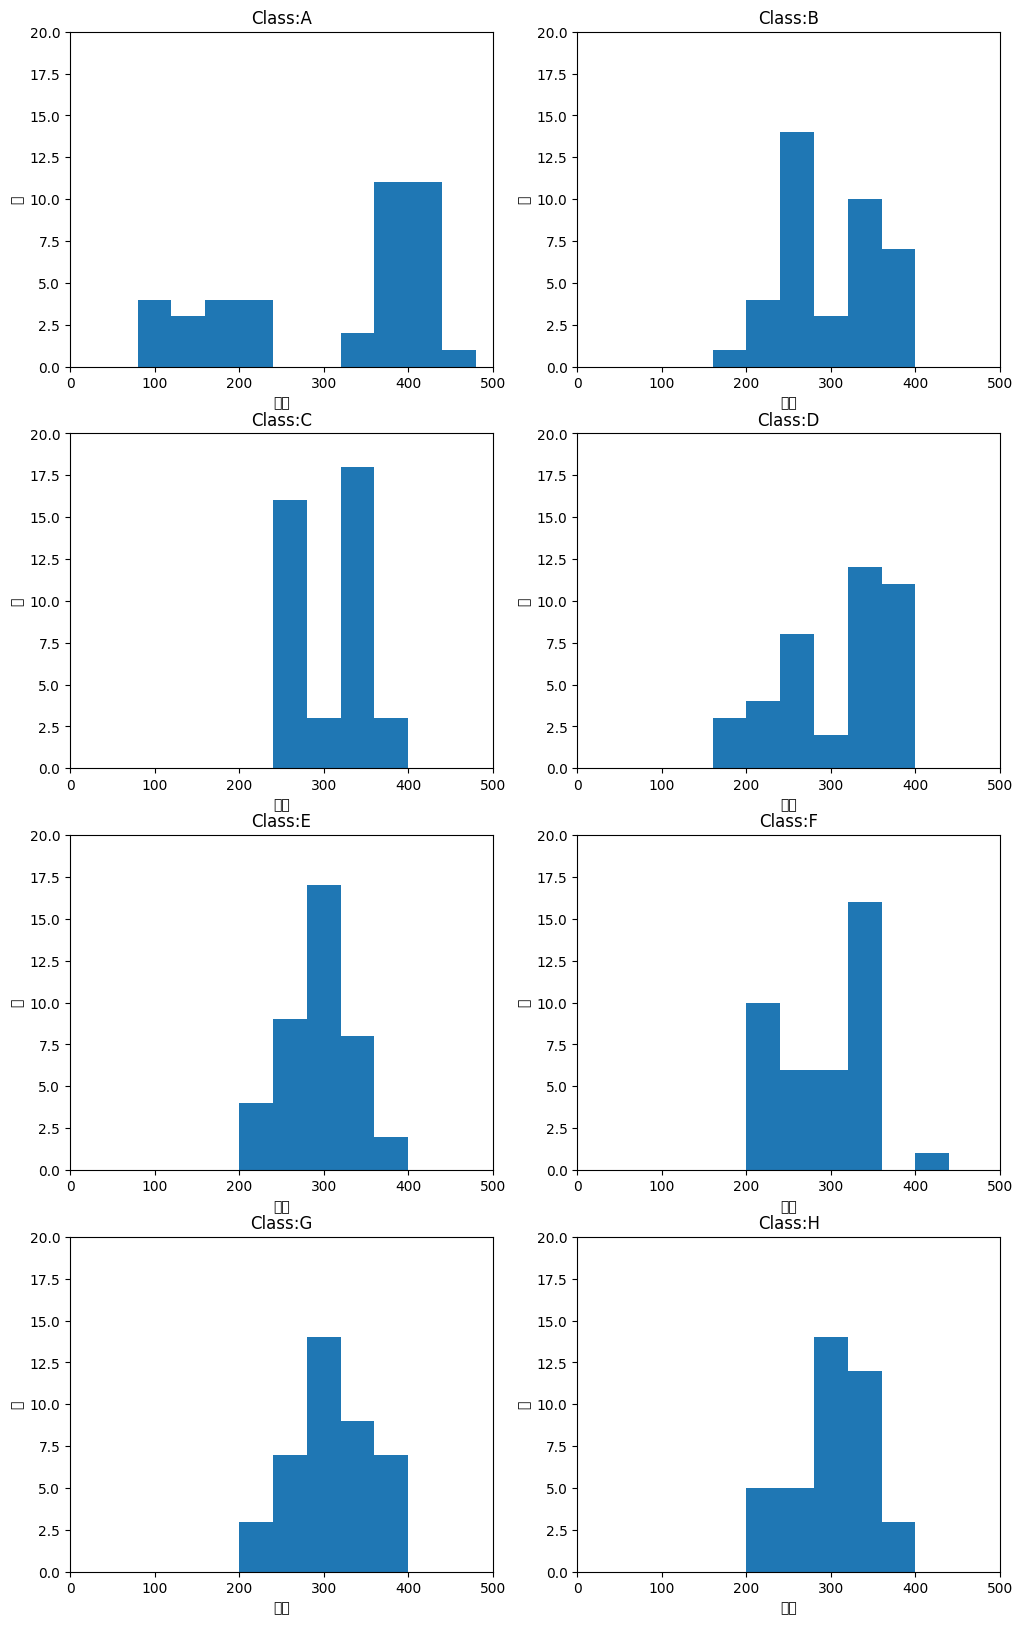

In [52]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt

s_df = pd.read_csv("students.csv")
s_pair_df = pd.read_csv("student_pairs.csv")

prob = pulp.LpProblem("ClassAssingnmentProblem",pulp.LpMaximize)

S = s_df["student_id"].tolist()
C = ["A","B","C","D","E","F","G","H"]
SC = [(s,c) for s in S for c in C]

x = pulp.LpVariable.dicts("x",SC,cat="Binary")

for s in S:
    prob += pulp.lpSum(x[s,c] for c in C) == 1
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40
    
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

score = {row.student_id:row.score for row in s_df.itertuples()}
score_mean = s_df["score"].mean()

for c in C:
    prob += (score_mean-10)*pulp.lpSum([x[s,c] for s in S]) <= pulp.lpSum([x[s,c]*score[s] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10)*pulp.lpSum([x[s,c]] for s in S)
    
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1
    
SS = [(row.student_id1 , row.student_id2) for row in s_pair_df.itertuples()]

for s1,s2 in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

status = prob.solve()
print(status)
print(pulp.LpStatus[status])

C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value() == 1]
    
for c ,Ss in C2Ss.items():
    print("Class:",c)
    print("人数:",len(Ss))
    print("学生:",Ss)
    print()
for s in S:
    assigned_class = [x[s,c].value() for c in C if x[s,c].value() == 1]
    if len(assigned_class) != 1:
        print("error:",s,assigned_class)

result_df = s_df.copy()
S2C = {s:c for s in S for c in C if x[s,c].value() == 1}
result_df["assigned_class"] = result_df["student_id"].map(S2C)

for i , (s1,s2) in enumerate(SS):
    print("case:",i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print("s1:{}-{}".format(s1,c1))
    print("s2:{}-{}".format(s2,c2))
    
fig = plt.figure(figsize=(12,20))

for i,c in enumerate(C):
    cls_df = result_df[result_df["assigned_class"] == c]
    ax = fig.add_subplot(4,2,i+1,xlabel="点数",ylabel ="人",xlim = (0,500),ylim = (0,20),title = "Class:{:s}".format(c))
    ax.hist(cls_df["score"],bins = range(0,500,40))

c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yhira\anaconda3\envs\only-pip\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  fig.canvas.print_figure(bytes

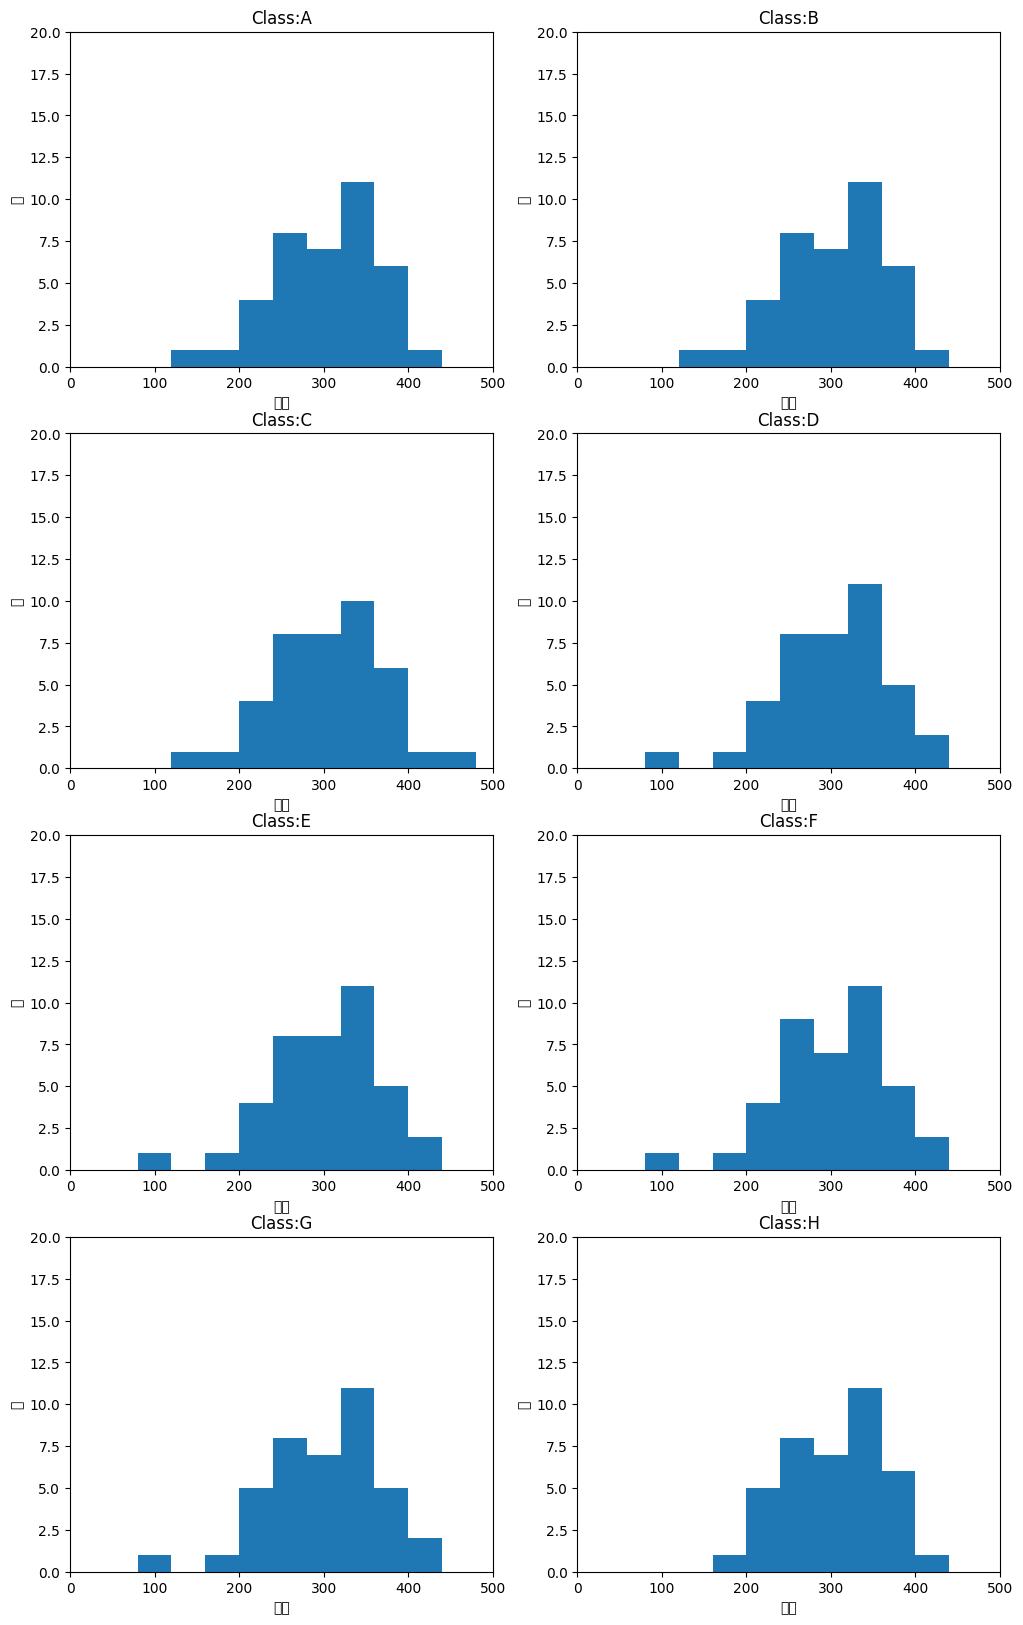

In [53]:
s_df["score_rank"] = s_df["score"].rank(ascending=False,method="first")
class_dic = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H"}
s_df["init_assigned_class"] = s_df["score_rank"].map(lambda x:x %8).map(class_dic)

init_flag = {(s,c):0 for s in S for c in C}

for row in s_df.itertuples():
    init_flag[row.student_id,row.init_assigned_class] = 1

fig = plt.figure(figsize=(12,20))
for i , c in enumerate(C):
    cls_df = s_df[s_df["init_assigned_class"] == c]
    ax = fig.add_subplot(4,2,i+1,xlabel="点数",ylabel ="人",xlim = (0,500),ylim = (0,20),title = "Class:{:s}".format(c))
    ax.hist(cls_df["score"],bins=range(0,500,40))
    
prob += pulp.lpSum([x[s,c]*init_flag[s,c] for s,c in SC])

# メモ

In [54]:
s_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<Axes: >

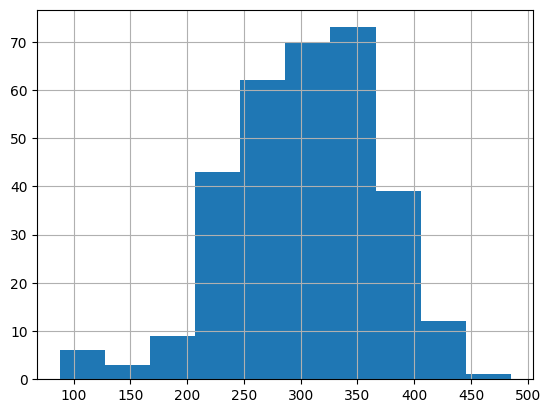

In [55]:
s_df["score"].hist()

In [56]:
s_df["leader_flag"].value_counts()

leader_flag
0    301
1     17
Name: count, dtype: int64

In [57]:
print(S_male)
print(S_female)

[2, 5, 8, 9, 11, 15, 22, 24, 26, 27, 28, 29, 30, 34, 37, 42, 43, 44, 47, 49, 51, 52, 55, 58, 60, 61, 62, 63, 64, 66, 67, 68, 72, 76, 77, 80, 81, 82, 86, 89, 91, 93, 94, 96, 98, 99, 101, 102, 103, 105, 108, 110, 111, 112, 115, 116, 120, 121, 122, 126, 128, 129, 130, 131, 132, 133, 136, 139, 140, 141, 142, 143, 144, 147, 148, 150, 154, 156, 157, 160, 165, 166, 168, 169, 170, 171, 172, 175, 176, 177, 178, 182, 183, 185, 188, 190, 191, 193, 194, 198, 202, 203, 204, 206, 207, 210, 211, 212, 213, 214, 219, 220, 221, 223, 224, 225, 226, 227, 229, 232, 234, 236, 237, 240, 243, 245, 246, 247, 250, 254, 255, 256, 257, 258, 265, 266, 267, 271, 272, 274, 275, 277, 278, 280, 287, 289, 291, 293, 294, 301, 302, 303, 304, 310, 311, 312, 315, 317]
[1, 3, 4, 6, 7, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 31, 32, 33, 35, 36, 38, 39, 40, 41, 45, 46, 48, 50, 53, 54, 56, 57, 59, 65, 69, 70, 71, 73, 74, 75, 78, 79, 83, 84, 85, 87, 88, 90, 92, 95, 97, 100, 104, 106, 107, 109, 113, 114, 117, 118, 119, 1

In [58]:
print(score)
print(score[1])
print(score_mean)

{1: 335, 2: 379, 3: 350, 4: 301, 5: 317, 6: 390, 7: 322, 8: 317, 9: 390, 10: 357, 11: 252, 12: 285, 13: 218, 14: 260, 15: 347, 16: 358, 17: 291, 18: 335, 19: 437, 20: 200, 21: 361, 22: 312, 23: 342, 24: 303, 25: 275, 26: 292, 27: 268, 28: 261, 29: 339, 30: 296, 31: 261, 32: 309, 33: 295, 34: 292, 35: 397, 36: 326, 37: 283, 38: 291, 39: 408, 40: 317, 41: 241, 42: 380, 43: 340, 44: 341, 45: 276, 46: 336, 47: 291, 48: 245, 49: 352, 50: 267, 51: 189, 52: 337, 53: 379, 54: 264, 55: 332, 56: 275, 57: 290, 58: 279, 59: 327, 60: 315, 61: 258, 62: 334, 63: 122, 64: 222, 65: 421, 66: 314, 67: 349, 68: 385, 69: 256, 70: 206, 71: 88, 72: 326, 73: 352, 74: 439, 75: 273, 76: 231, 77: 284, 78: 278, 79: 367, 80: 233, 81: 283, 82: 247, 83: 413, 84: 212, 85: 366, 86: 344, 87: 215, 88: 123, 89: 350, 90: 220, 91: 351, 92: 383, 93: 352, 94: 316, 95: 337, 96: 300, 97: 350, 98: 352, 99: 409, 100: 336, 101: 224, 102: 369, 103: 233, 104: 209, 105: 322, 106: 355, 107: 346, 108: 390, 109: 102, 110: 239, 111: 335

In [59]:
print(SS)

[(118, 189), (72, 50), (314, 233)]


In [60]:
print(C2Ss)

{'A': [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298], 'B': [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317], 'C': [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318], 'D': [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316], 'E': [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197, 243, 244, 247, 249, 250, 269, 271, 288, 300, 305, 309, 310, 315], 'F': [12, 17, 40, 45, 46, 74, 76, 80, 95

In [61]:
result_df

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,B
1,2,1,0,0,379,A
2,3,0,0,0,350,C
3,4,0,0,0,301,E
4,5,1,0,0,317,E
...,...,...,...,...,...,...
313,314,0,0,0,244,H
314,315,1,0,0,309,E
315,316,0,0,0,239,D
316,317,1,0,0,356,B


In [62]:
result_df.groupby("assigned_class")["student_id"].count()

assigned_class
A    40
B    39
C    40
D    40
E    40
F    40
G    40
H    39
Name: student_id, dtype: int64

In [63]:
result_df.groupby(["assigned_class","gender"])["student_id"].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         19
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         20
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [64]:
result_df.groupby("assigned_class")["score"].mean()

assigned_class
A    306.875000
B    293.717949
C    312.125000
D    309.850000
E    294.550000
F    299.525000
G    313.200000
H    298.948718
Name: score, dtype: float64

In [65]:
result_df.groupby("assigned_class")["leader_flag"].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [66]:
result_df.groupby("assigned_class")["support_flag"].sum()

assigned_class
A    0
B    0
C    1
D    0
E    1
F    0
G    1
H    1
Name: support_flag, dtype: int64